# News Popularity Prediction



## 1. Loading dependencies & datasets

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from scipy.stats import mstats
from sklearn.metrics import classification_report
import os
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, accuracy_score, precision_score,\
                            recall_score, f1_score, confusion_matrix, classification_report

# hide warnings
import warnings
warnings.filterwarnings('ignore')

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

Lets analyse the features that are given to us. As detailed in the Data section of the competition page, the features provided come from different sources and have been categorized into various types. Some of these are coming directly from other NLP (Natural language processing) models. Let's print and try to categorize the variable names for better analysis.

In [169]:
df = pd.read_csv("train.csv")
df_dict=pd.read_csv("data_dictionary.csv")

In [170]:
for i in df_dict.iterrows():
    print(i[1]['column'],':',i[1]['description'])

url : URL of the article (non-predictive)
timedelta : Days between the article publication and the dataset acquisition (non-predictive)
ntokenstitle : Number of words in the title
ntokenscontent : Number of words in the content
nuniquetokens : Rate of unique words in the content
nnonstop_words : Rate of non-stop words in the content
nnonstopuniquetokens : Rate of unique non-stop words in the content
num_hrefs : Number of links
numselfhrefs : Number of links to other articles published by Mashable
num_imgs : Number of images
num_videos : Number of videos
averagetokenlength : Average length of the words in the content
numkeywords : Number of keywords in the metadata
datachannelislifestyle : Is data channel 'Lifestyle'?
datachannelis_entertainment : Is data channel 'Entertainment'?
datachannelis_bus : Is data channel 'Business'?
datachannelis_socmed : Is data channel 'Social Media'?
datachannelis_tech : Is data channel 'Tech'?
datachannelis_world : Is data channel 'World'?
kwminmin : Wors

In [171]:
word_features = ['n_tokens_title', 
                 'n_tokens_content', 
                 'n_unique_tokens', 
                 'n_non_stop_words', 
                 'n_non_stop_unique_tokens', 
                 'average_token_length']

media_features = ['num_imgs', 'num_videos']

temporal_features = ['weekday_is_monday', 
                     'weekday_is_tuesday', 
                     'weekday_is_wednesday',
                     'weekday_is_thursday',
                     'weekday_is_friday',
                     'weekday_is_saturday',
                     'weekday_is_sunday',
                     'is_weekend']

channel_features = ['data_channel_is_lifestyle', 'data_channel_is_entertainment', 
                    'data_channel_is_bus', 'data_channel_is_socmed', 
                    'data_channel_is_tech', 'data_channel_is_world']

keyword_features = ['kw_min_min', 'kw_max_min', 'kw_avg_min',
                    'kw_min_max', 'kw_max_max', 'kw_avg_max', 
                    'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
                    'num_keywords']


reference_features = ['num_hrefs',
                      'num_self_hrefs',
                      'self_reference_min_shares',
                      'self_reference_max_shares',
                      'self_reference_avg_sharess']

topic_features = ['LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04']

subjectivity_features = ['global_subjectivity', 'title_subjectivity', 'abs_title_subjectivity']

sentiment_features = ['global_sentiment_polarity', 'global_rate_positive_words',
                      'global_rate_negative_words', 'rate_positive_words',
                      'rate_negative_words', 'avg_positive_polarity',
                      'min_positive_polarity', 'max_positive_polarity',
                      'avg_negative_polarity', 'min_negative_polarity',
                      'max_negative_polarity', 'title_sentiment_polarity',
                      'abs_title_sentiment_polarity']

ids = ['id']

others = ['url']

target = ['shares']

In [172]:
features = [*ids, *word_features, *media_features, 
            *temporal_features, *channel_features, 
            *keyword_features, *reference_features, 
            *topic_features, *subjectivity_features, 
            *sentiment_features, *others, *target]

len(features), len(df.columns)

(61, 61)

In [173]:
df.shape

(29733, 61)

## 2. Create X, y and then Train test split

Lets create X and y datasets and then split them into train and test, before we do any form of transformations on the data or cleaning.

> Important: For the purpose of this **starter notebook**, we I will restrict the dataset to only a small set of variables. However, for building your models and submission files, please ensure to select from all the features given so as to ensure good ranking on the leaderboard.

In [174]:


selected_features = [*ids, *word_features, *channel_features, *temporal_features, *subjectivity_features]
print(len(selected_features))


24


In [175]:
X = df[selected_features].set_index('id')
y = df[target]

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

[i.shape for i in [X_train, X_test, y_train, y_test]]

[(20813, 23), (8920, 23), (20813, 1), (8920, 1)]

In [177]:
X_train.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,average_token_length,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,...,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,global_subjectivity,title_subjectivity,abs_title_subjectivity
id,,,,,,,,,,,,,,,,,,,,,
20654,14.0,363.0,0.495627,1.0,0.523985,4.980716,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.375000,NaN
24642,7.0,719.0,0.437143,1.0,0.617284,4.376912,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.500030,0.000000,0.500000
12014,15.0,458.0,0.512088,1.0,0.662879,4.949782,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.385503,0.454545,0.045455
29481,11.0,217.0,0.591549,1.0,0.775194,4.930876,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,NaN,0.0,0.369697,0.000000,0.500000
4227,10.0,467.0,0.522831,1.0,0.614887,4.845824,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,NaN,0.0,0.428351,0.443939,0.056061


In [178]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20813 entries, 20654 to 9376
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   n_tokens_title                 20813 non-null  float64
 1   n_tokens_content               20813 non-null  float64
 2   n_unique_tokens                20813 non-null  float64
 3   n_non_stop_words               20813 non-null  float64
 4   n_non_stop_unique_tokens       20813 non-null  float64
 5   average_token_length           20813 non-null  float64
 6   data_channel_is_lifestyle      20813 non-null  float64
 7   data_channel_is_entertainment  20813 non-null  float64
 8   data_channel_is_bus            20813 non-null  float64
 9   data_channel_is_socmed         20813 non-null  float64
 10  data_channel_is_tech           20813 non-null  float64
 11  data_channel_is_world          20813 non-null  float64
 12  weekday_is_monday              20135 non-nu

In [179]:
X_train.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,average_token_length,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,...,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,global_subjectivity,title_subjectivity,abs_title_subjectivity
count,20813.000000,20813.000000,20813.000000,20813.000000,20813.000000,20813.000000,20813.000000,20813.000000,20813.000000,20813.000000,...,20283.000000,19703.000000,20590.000000,20200.000000,20745.000000,19749.000000,19303.000000,19223.000000,20721.000000,20257.000000
mean,10.395090,546.018738,0.564486,1.019603,0.704664,4.543156,0.053284,0.176524,0.159323,0.059386,...,0.187990,0.188144,0.184070,0.142624,0.061750,0.066484,0.128581,0.443746,0.282292,0.342411
std,2.121073,471.831121,4.857299,7.218036,4.503501,0.850437,0.224605,0.381275,0.365986,0.236351,...,0.390714,0.390837,0.387551,0.349697,0.240706,0.249133,0.334744,0.116824,0.324179,0.188235
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,246.000000,0.471483,1.000000,0.627119,4.477749,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.396938,0.000000,0.166667
50%,10.000000,408.000000,0.540000,1.000000,0.691710,4.664134,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.453606,0.150000,0.500000
75%,12.000000,716.000000,0.609319,1.000000,0.754617,4.850806,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.507943,0.500000,0.500000
max,23.000000,8474.000000,701.000000,1042.000000,650.000000,8.041534,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000


There seem to be some missing values in the count as shown by describe. Lets analyze and fix the same.

## 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

In [180]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent

n_tokens_title                   0.000000
n_tokens_content                 0.000000
n_unique_tokens                  0.000000
n_non_stop_words                 0.000000
n_non_stop_unique_tokens         0.000000
average_token_length             0.000000
data_channel_is_lifestyle        0.000000
data_channel_is_entertainment    0.000000
data_channel_is_bus              0.000000
data_channel_is_socmed           0.000000
data_channel_is_tech             0.000000
data_channel_is_world            0.000000
weekday_is_monday                3.257579
weekday_is_tuesday               2.546485
weekday_is_wednesday             5.333205
weekday_is_thursday              1.071446
weekday_is_friday                2.945275
weekday_is_saturday              0.326719
weekday_is_sunday                5.112189
is_weekend                       7.255081
global_subjectivity              7.639456
title_subjectivity               0.442031
abs_title_subjectivity           2.671407
dtype: float64

In [181]:
# Checking the percentage of missing values
missing_vals = round(100*(df.isnull().sum()/len(df.index)), 2).sort_values(ascending=False)
missing_vals.head(30)

num_imgs                        18.19
num_self_hrefs                  15.25
global_subjectivity              7.55
is_weekend                       7.29
self_reference_max_shares        5.93
weekday_is_wednesday             5.23
kw_max_max                       5.10
weekday_is_sunday                5.03
abs_title_sentiment_polarity     4.90
avg_positive_polarity            4.16
kw_min_min                       3.65
weekday_is_monday                3.30
kw_avg_avg                       3.27
global_rate_negative_words       2.99
weekday_is_friday                2.91
global_rate_positive_words       2.81
num_hrefs                        2.73
abs_title_subjectivity           2.69
min_negative_polarity            2.63
weekday_is_tuesday               2.53
max_negative_polarity            2.39
kw_max_avg                       2.29
rate_negative_words              1.99
num_videos                       1.97
rate_positive_words              1.97
num_keywords                     1.56
kw_max_min  

In [182]:
# Checking for null values
df.isnull().sum().sort_values(ascending=False).head(10)

num_imgs                        5407
num_self_hrefs                  4533
global_subjectivity             2246
is_weekend                      2168
self_reference_max_shares       1762
weekday_is_wednesday            1554
kw_max_max                      1515
weekday_is_sunday               1496
abs_title_sentiment_polarity    1457
avg_positive_polarity           1238
dtype: int64

In [183]:
X_train.fillna(0,inplace=True)

In [184]:
X_train.isnull().sum().sort_values(ascending=False).head(10)

n_tokens_title          0
weekday_is_monday       0
title_subjectivity      0
global_subjectivity     0
is_weekend              0
weekday_is_sunday       0
weekday_is_saturday     0
weekday_is_friday       0
weekday_is_thursday     0
weekday_is_wednesday    0
dtype: int64

In [185]:
df.fillna(0,inplace=True)

In [186]:
X_test.fillna(0,inplace=True)

## 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<AxesSubplot:>

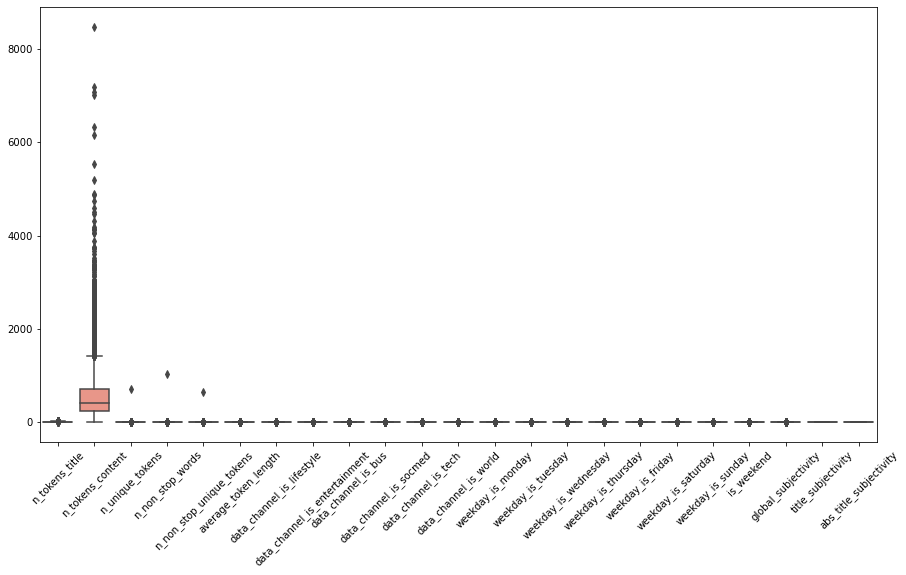

In [187]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train)

In [188]:
median_share = df['shares'].median()
print(f'Median  = {median_share}')

Median  = 1400.0


In [189]:
df['popularity'] = df['shares'].apply(lambda x: 1 if x>=1400  else 0)

In [190]:
unpopular=df[df['shares']<1400]
popular=df[df['shares']>=1400]

In [191]:
unpopular.shape

(13842, 62)

In [192]:
popular.shape

(15891, 62)

In [193]:
day_of_week = df.columns.values[31:38]
day_of_week

array(['weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
       'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday',
       'weekday_is_sunday'], dtype=object)

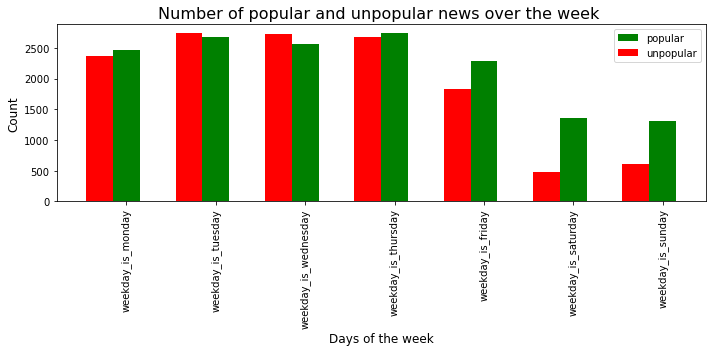

In [194]:
Unpop_day = unpopular[day_of_week].sum().values
Pop_day = popular[day_of_week].sum().values

fig = plt.figure(figsize = (10,5))
plt.title("Number of popular and unpopular news over the week ", fontsize = 16)
plt.bar(np.arange(len(day_of_week)), Pop_day, width = 0.3, align="center", color = 'g', \
          label = "popular")
plt.bar(np.arange(len(day_of_week)) - 0.3, Unpop_day, width = 0.3, align = "center", color = 'r', \
          label = "unpopular")
plt.xticks(np.arange(len(day_of_week)), day_of_week, rotation=90)
plt.ylabel("Count", fontsize = 12)
plt.xlabel("Days of the week", fontsize = 12)
    
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

The number of popular as well as unpopular news is the high on the week days

In [195]:
DataChannels = df.columns.values[14:19]
DataChannels

array(['data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world'], dtype=object)

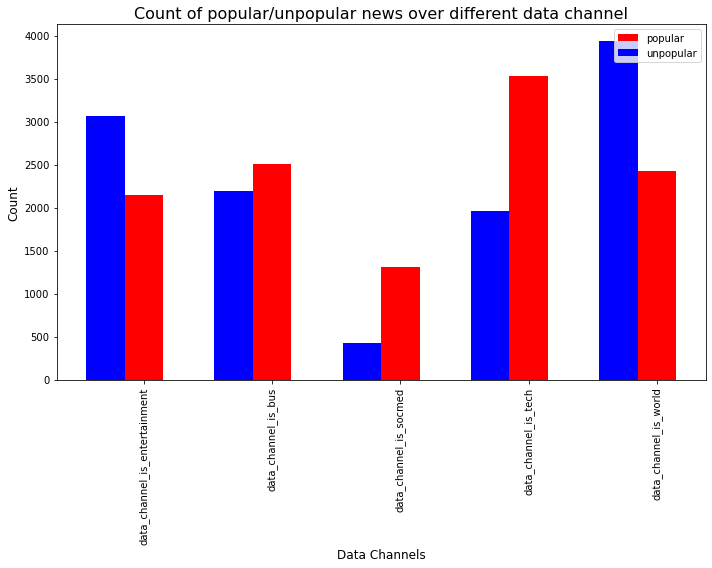

In [196]:
Unpop=df[df['shares']<median_share]
Pop=df[df['shares']>=median_share]
Unpop_day = Unpop[DataChannels].sum().values
Pop_day = Pop[DataChannels].sum().values
fig = plt.figure(figsize = (10,8))
plt.title("Count of popular/unpopular news over different data channel", fontsize = 16)
plt.bar(np.arange(len(DataChannels)), Pop_day, width = 0.3, align="center", color = 'r', \
          label = "popular")
plt.bar(np.arange(len(DataChannels)) - 0.3, Unpop_day, width = 0.3, align = "center", color = 'b', \
          label = "unpopular")
plt.xticks(np.arange(len(DataChannels)), DataChannels,rotation=90)
plt.ylabel("Count", fontsize = 12)
plt.xlabel("Data Channels", fontsize = 12)
    
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

Most of the news is shared through enetertainment and business channels

In [197]:
keyWords=df.columns.values[19:28]
keyWords

array(['kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max',
       'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg'], dtype=object)

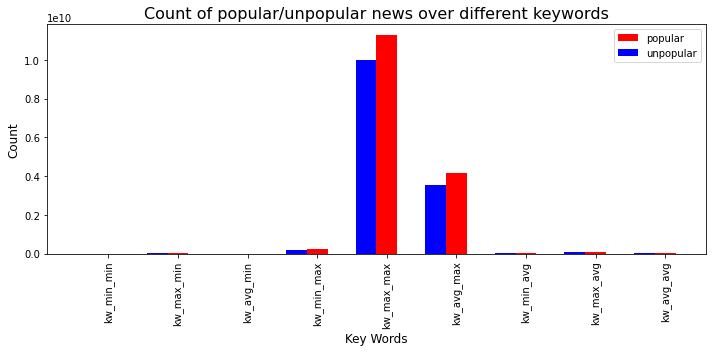

In [198]:
Unpop=df[df['shares']<median_share]
Pop=df[df['shares']>=median_share]
Unpop_day = Unpop[keyWords].sum().values
Pop_day = Pop[keyWords].sum().values
fig = plt.figure(figsize = (10,5))
plt.title("Count of popular/unpopular news over different keywords", fontsize = 16)
plt.bar(np.arange(len(keyWords)), Pop_day, width = 0.3, align="center", color = 'r', \
          label = "popular")
plt.bar(np.arange(len(keyWords)) - 0.3, Unpop_day, width = 0.3, align = "center", color = 'b', \
          label = "unpopular")
plt.xticks(np.arange(len(keyWords)), keyWords,rotation=90)
plt.ylabel("Count", fontsize = 12)
plt.xlabel("Key Words", fontsize = 12)
    
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

Most articles use the best and average keywords and those articles are also the most popular




In [199]:
rates=df.columns.values[46:50]
rates

array(['global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words'], dtype=object)

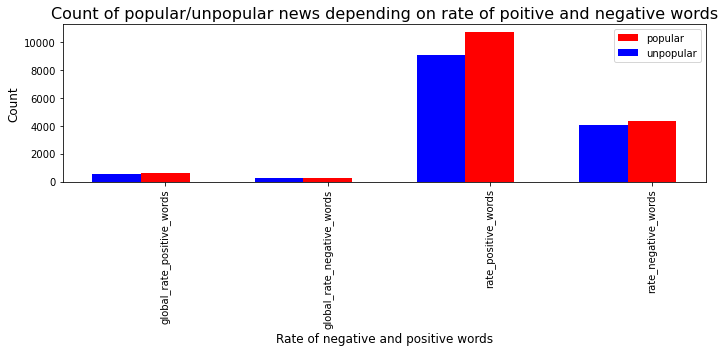

In [200]:
Unpop=df[df['shares']<median_share]
Pop=df[df['shares']>=median_share]
Unpop_day = Unpop[rates].sum().values
Pop_day = Pop[rates].sum().values
fig = plt.figure(figsize = (10,5))
plt.title("Count of popular/unpopular news depending on rate of poitive and negative words", fontsize = 16)
plt.bar(np.arange(len(rates)), Pop_day, width = 0.3, align="center", color = 'r', \
          label = "popular")
plt.bar(np.arange(len(rates)) - 0.3, Unpop_day, width = 0.3, align = "center", color = 'b', \
          label = "unpopular")
plt.xticks(np.arange(len(rates)), rates,rotation=90)
plt.ylabel("Count", fontsize = 12)
plt.xlabel("Rate of negative and positive words", fontsize = 12)
    
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

In [201]:
# all numeric (float and int) variables in the dataset
df_numeric = df.select_dtypes(include=['float64', 'int64'])
df_numeric.head()

,id,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,popularity
0,0,8.0,211.0,0.629808,1.0,0.800000,6.0,3.0,0.0,0.0,...,0.6,-0.100000,0.0000,-0.100000,1.000000,0.600000,0.500000,0.600000,36700,1
1,1,12.0,416.0,0.603535,1.0,0.663580,22.0,7.0,1.0,16.0,...,1.0,-0.228621,-0.5000,-0.071429,0.000000,0.000000,0.500000,0.000000,24200,1
2,2,7.0,229.0,0.638393,1.0,0.746479,9.0,4.0,1.0,1.0,...,1.0,-0.260833,-0.5000,-0.166667,0.000000,0.000000,0.500000,0.000000,945,0
3,3,9.0,473.0,0.542373,1.0,0.752809,7.0,0.0,1.0,1.0,...,0.7,-0.167500,-0.2500,-0.100000,0.000000,0.000000,0.500000,0.000000,844,0
4,4,13.0,1097.0,0.505213,1.0,0.676343,10.0,4.0,14.0,0.0,...,1.0,-0.193182,-0.3125,-0.100000,0.383333,0.166667,0.116667,0.166667,551,0


<Figure size 1440x1800 with 0 Axes>

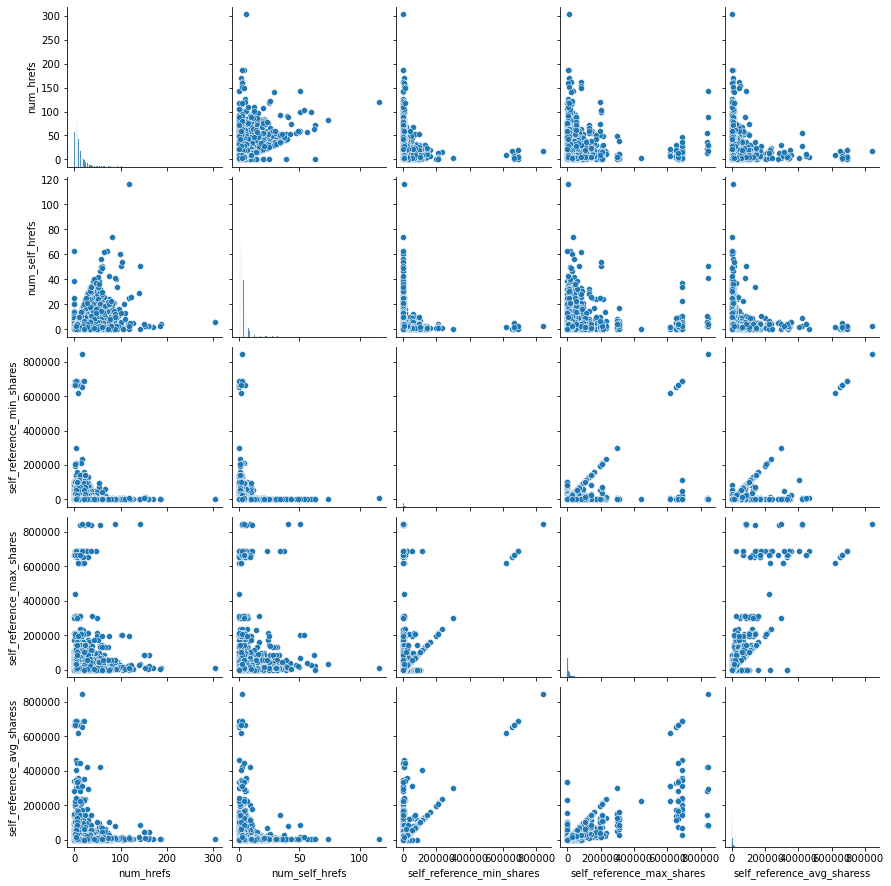

In [202]:
plt.figure(figsize=(20,25))
sns.pairplot(data=df, vars=reference_features)
plt.show()

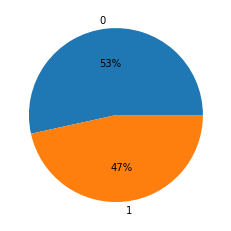

In [203]:
#Check the % of articles that ae popular
plt.pie(df['popularity'].value_counts(),labels = ['0','1'], autopct='%.0f%%')
plt.show()

53% of the articles are unpopular and 47% are popular

### CORRELATION MATRIX

In [204]:
# correlation matrix
corr = df_numeric.corr()
corr

,id,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,popularity
id,1.000000,0.003322,-0.004220,-0.004725,-0.004940,-0.004727,-0.005221,0.000737,-0.019720,0.007159,...,-0.004503,-0.000390,-0.002547,-0.000167,-0.007220,-0.020693,-0.000729,-0.002503,-0.002531,-0.000990
n_tokens_title,0.003322,1.000000,0.016609,-0.005735,-0.005177,-0.005801,-0.053159,-0.016558,-0.013424,0.052944,...,-0.019711,-0.015158,-0.026993,0.014186,0.078717,0.004385,-0.145128,0.043051,0.011883,-0.046668
n_tokens_content,-0.004220,0.016609,1.000000,-0.000818,0.018492,0.003676,0.416523,0.266765,0.312096,0.102358,...,0.408467,-0.131288,-0.432945,0.215736,0.002679,0.019025,0.008128,0.009012,0.005995,0.041279
n_unique_tokens,-0.004725,-0.005735,-0.000818,1.000000,0.999680,0.999888,-0.003456,0.009752,0.028063,-0.000930,...,-0.011547,0.003947,0.010434,-0.004556,-0.005302,-0.002422,-0.009926,-0.004321,0.000890,0.003814
n_non_stop_words,-0.004940,-0.005177,0.018492,0.999680,1.000000,0.999653,0.004957,0.014988,0.035576,-0.001176,...,-0.002079,0.001397,0.001190,0.000767,-0.005966,-0.001882,-0.009376,-0.004578,0.000646,0.004942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
title_sentiment_polarity,-0.020693,0.004385,0.019025,-0.002422,-0.001882,-0.002980,0.035984,0.021141,0.043200,0.018248,...,0.067913,0.090728,0.081678,0.001372,0.230843,1.000000,-0.228945,0.386460,0.012835,0.061892
abs_title_subjectivity,-0.000729,-0.145128,0.008128,-0.009926,-0.009376,-0.009404,0.010089,0.005672,-0.009757,-0.018365,...,-0.011301,-0.011725,-0.012493,-0.010244,-0.458763,-0.228945,1.000000,-0.364689,-0.001930,0.000810
abs_title_sentiment_polarity,-0.002503,0.043051,0.009012,-0.004321,-0.004578,-0.005270,0.052924,-0.004076,0.053876,0.050264,...,0.072041,-0.068126,-0.052095,-0.014055,0.691089,0.386460,-0.364689,1.000000,0.027917,0.038185
shares,-0.002531,0.011883,0.005995,0.000890,0.000646,0.000273,0.047949,-0.002513,0.037823,0.022564,...,0.011781,-0.028994,-0.017326,-0.019940,0.024579,0.012835,-0.001930,0.027917,1.000000,0.193378


In [205]:
# # Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# # Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# # Drop features 
df.drop(to_drop, axis=1, inplace=True)


In [206]:
df.shape

(29733, 57)

<AxesSubplot:ylabel='Density'>

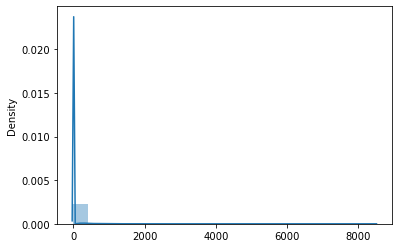

In [207]:
sns.distplot(X_train,bins=20)

<AxesSubplot:ylabel='Density'>

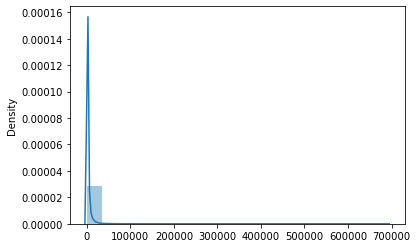

In [208]:
sns.distplot(y_train,bins=20)

<AxesSubplot:ylabel='Density'>

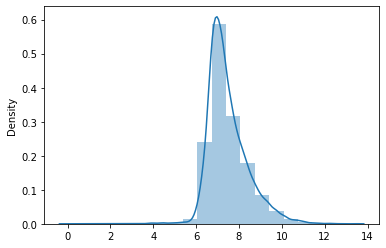

In [209]:
sns.distplot(np.log(y_train),bins=20)

The data was skewed but we can apply log transformaation to fix that

### 4.1 Feature scaling

Clearly there is a need for scaling the features so that the distributions can be analysed further. We can use StandardScaler for this purpose (few other alternates are min-max scaling and Z-scaling).

In [210]:
X_train_cat = X_train.select_dtypes(include=['object'])

In [211]:
# drop categorical variables 
X_train = X_train.drop(list(X_train_cat.columns), axis=1)

In [212]:
scale = StandardScaler()
X_train[:] = scale.fit_transform(X_train)

In [213]:
# X_train[:] = np.log(X_train)

<AxesSubplot:>

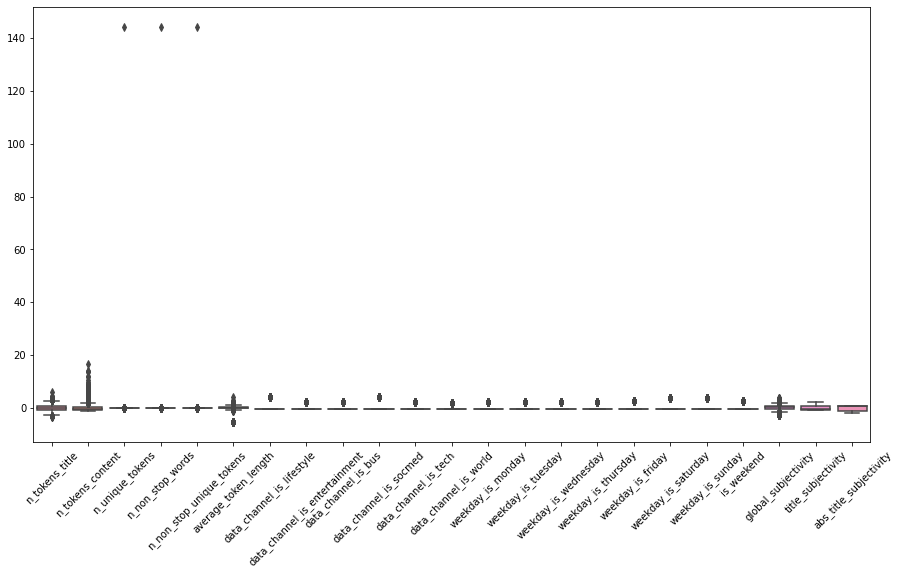

In [214]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train)

### 4.2 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [215]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [216]:
X_train = X_train.apply(cap_outliers, axis=0)

<AxesSubplot:>

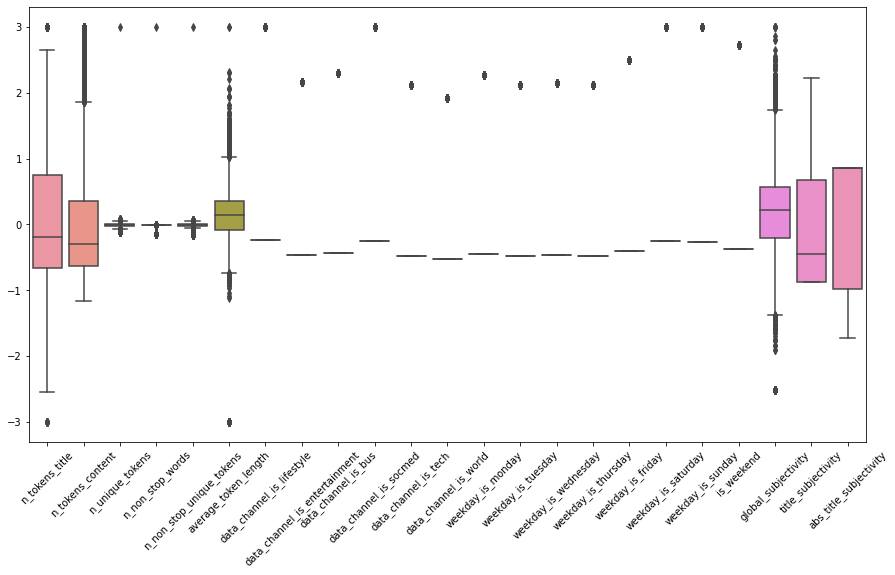

In [217]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train)

You can perform feature transformations at this stage. 

1. **Positively skewed:** Common transformations of this data include square root, cube root, and log.
2. **Negatively skewed:** Common transformations include square, cube root and logarithmic.


<AxesSubplot:>

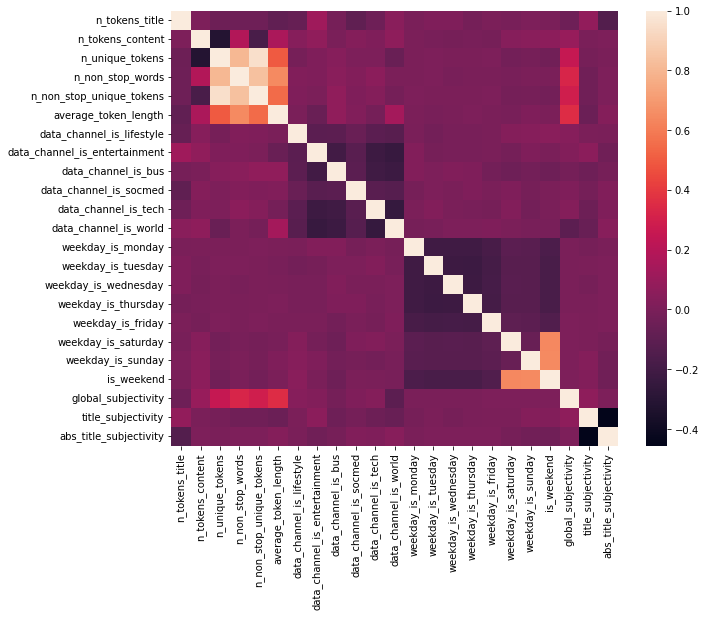

In [218]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train, columns=X_train.columns).corr())

<AxesSubplot:ylabel='Count'>

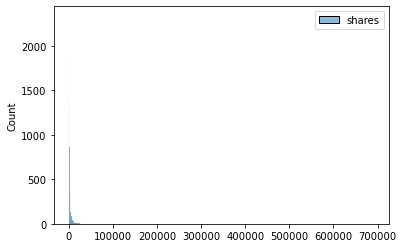

In [219]:
#Distribution for the target variable
sns.histplot(y_train)

<AxesSubplot:ylabel='Count'>

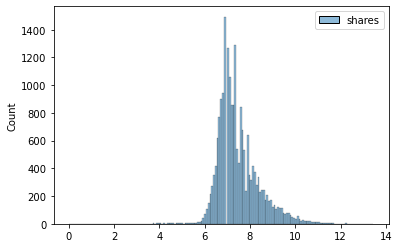

In [220]:
sns.histplot(np.log(y_train))

In [221]:
y_train=np.log(y_train)

In [222]:
X_train.isnull().sum()

n_tokens_title                   0
n_tokens_content                 0
n_unique_tokens                  0
n_non_stop_words                 0
n_non_stop_unique_tokens         0
average_token_length             0
data_channel_is_lifestyle        0
data_channel_is_entertainment    0
data_channel_is_bus              0
data_channel_is_socmed           0
data_channel_is_tech             0
data_channel_is_world            0
weekday_is_monday                0
weekday_is_tuesday               0
weekday_is_wednesday             0
weekday_is_thursday              0
weekday_is_friday                0
weekday_is_saturday              0
weekday_is_sunday                0
is_weekend                       0
global_subjectivity              0
title_subjectivity               0
abs_title_subjectivity           0
dtype: int64

### 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [223]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train.to_numpy().reshape(-1,))

RandomForestRegressor(n_jobs=-1)

In [224]:
feature_importances = pd.DataFrame({'col':X_train.columns, 'importance':rf.feature_importances_})

<BarContainer object of 23 artists>

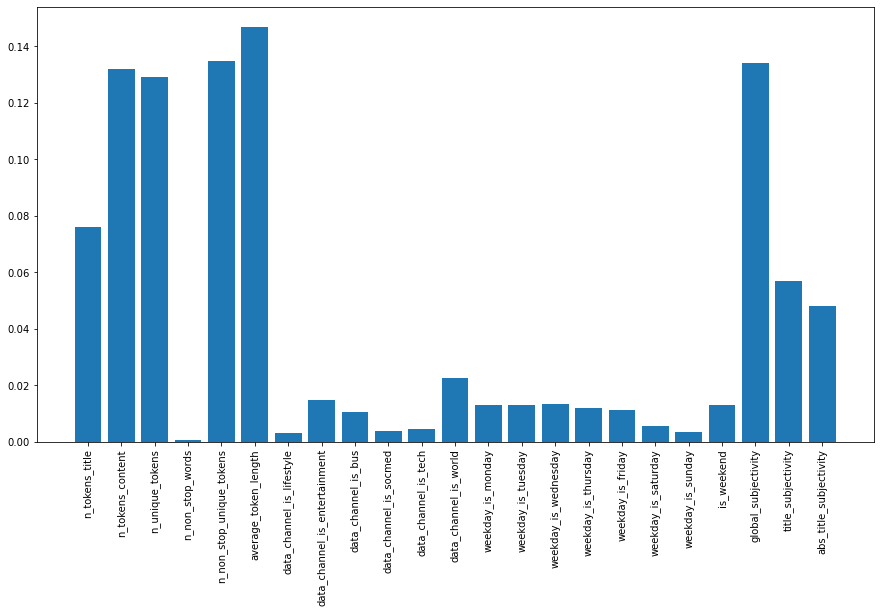

In [225]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
plt.bar(feature_importances['col'], feature_importances['importance'])

Let's use PCA for dimensionality reduction.

In [226]:
X_train.shape


(20813, 23)

In [227]:
from sklearn.decomposition import PCA

In [228]:
pca = PCA(random_state=42)
pca.fit(X_train)

PCA(random_state=42)

In [229]:
pca.components_

array([[ 7.01640841e-02,  7.41989964e-02, -1.03164185e-03,
         1.14141533e-04, -1.13675698e-03, -3.75767335e-03,
         4.33705269e-02,  8.70810188e-02, -1.03488988e-01,
        -5.36064383e-03, -8.99074612e-03, -3.99178008e-02,
        -1.16238038e-01, -1.35013674e-01, -1.39792993e-01,
        -1.40891674e-01, -9.40473066e-02,  3.67309794e-01,
         3.91108103e-01,  7.14220379e-01,  5.06418644e-02,
         2.06938452e-01, -2.10522263e-01],
       [ 3.02412780e-01, -2.32477010e-02,  1.17908099e-04,
        -1.10095754e-03, -8.47110735e-04, -5.69984750e-02,
        -2.55138201e-02,  3.07044419e-01,  5.33603830e-03,
        -3.93650316e-02, -1.21779184e-01, -1.75508674e-01,
         6.36191081e-02,  5.42222341e-02,  2.94909343e-02,
         2.15888443e-02,  4.20057889e-02, -1.48964076e-01,
        -1.09227412e-01, -2.40288487e-01,  4.32879325e-02,
         5.74001689e-01, -5.73861940e-01],
       [ 2.53034573e-01,  5.19140335e-03, -4.21243934e-03,
        -4.05630205e-03, -4.9

In [230]:
pca.explained_variance_ratio_

array([9.80220571e-02, 8.81999602e-02, 7.50948220e-02, 7.05786079e-02,
       7.00895928e-02, 6.96043969e-02, 6.85948432e-02, 6.70358683e-02,
       6.59806695e-02, 6.26354112e-02, 5.27720532e-02, 4.23721708e-02,
       3.81321579e-02, 3.73198703e-02, 3.30233552e-02, 3.06459834e-02,
       1.69631932e-02, 8.15665288e-03, 2.84854234e-03, 1.80364132e-03,
       1.17683631e-04, 6.52019940e-06, 1.94646272e-06])

In [231]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

### SCREE PLOT

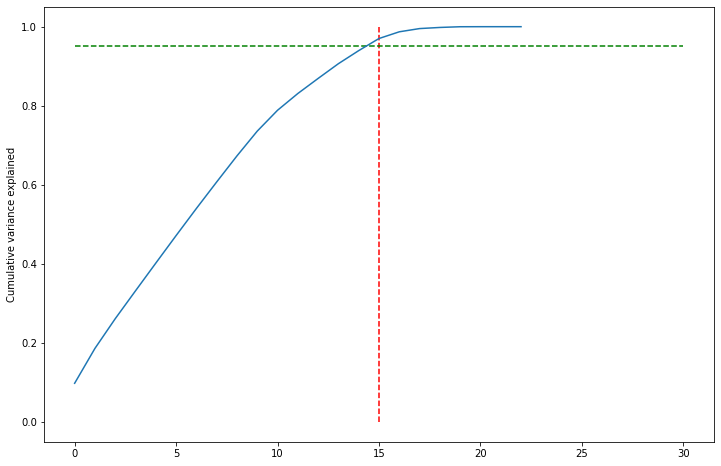

In [232]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=15, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

#### 15 features explain about 93% of variance

In [233]:
from sklearn.decomposition import IncrementalPCA

In [234]:
pca_final = IncrementalPCA(n_components=15)

In [235]:
df_train_pca = pca_final.fit_transform(X_train)

In [236]:
df_train_pca.shape

(20813, 15)

In [237]:
corrmat = np.corrcoef(df_train_pca.transpose())

In [238]:
corrmat.shape

(15, 15)

<AxesSubplot:>

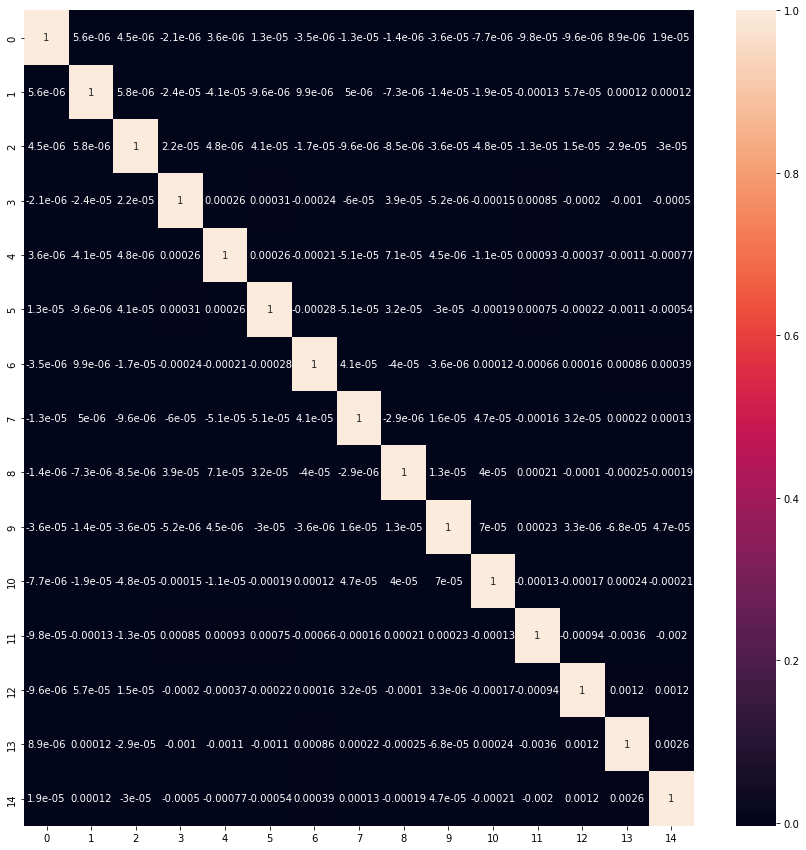

In [239]:
plt.figure(figsize=[15,15])
sns.heatmap(corrmat, annot=True)

In [240]:
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(8920, 15)

## Applying LR on the pca components

In [241]:
lm = LinearRegression()

In [242]:
lr_pca=lm.fit(df_train_pca, y_train)

In [243]:
df_test_pca=pca_final.fit_transform(X_test)

In [244]:
from sklearn.metrics import r2_score, mean_squared_error

In [245]:
y_pred_train = lr_pca.predict(df_train_pca)
y_pred_test = lr_pca.predict(df_test_pca)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.051780448694235925
-0.056954733857585094
shares    16989.274944
dtype: float64
shares    2.150244e+12
dtype: float64
0.8162818884403594
241058728.53202775


In [246]:
y_res_train = y_train - y_pred_train

In [247]:
df['res'] = y_res_train

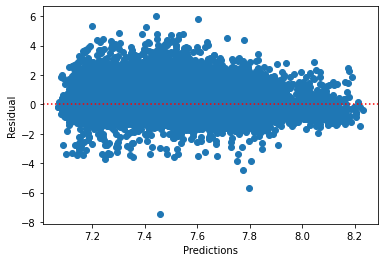

In [248]:
plt.scatter( y_pred_train , y_res_train)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("Predictions")
plt.ylabel("Residual")
plt.show()

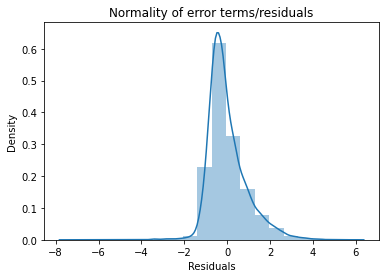

In [249]:
# Distribution of errors
p = sns.distplot(y_res_train,kde=True,bins=20)

p = plt.title('Normality of error terms/residuals')
plt.xlabel("Residuals")
plt.show()

The error terms do not show any pattern anad the distribution is also normal

## RIDGE REGRESSION

In [250]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(df_train_pca, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [251]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [252]:
#Fitting Ridge model for alpha = 0.0001 and printing coefficients which have been penalised

alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(df_train_pca, y_train) 

Lasso(alpha=0.0001)

In [253]:
lasso.coef_

array([ 0.07851075, -0.01199142, -0.10209938,  0.00374143,  0.01084795,
        0.00256184, -0.02720234, -0.04309237,  0.0210635 , -0.02427678,
       -0.01597854, -0.01723465,  0.12902189, -0.05207875,  0.06276242])

In [254]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(df_train_pca)
y_pred_test = lasso.predict(df_test_pca)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)


mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.05178027270255725
-0.05695474280958002
0.8162820399441115
241058730.57370126


## LASSO

In [255]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(df_train_pca, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [256]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [257]:
#Fitting Ridge model for alpha = 0.0001 and printing coefficients which have been penalised

alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(df_train_pca, y_train) 

Lasso(alpha=0.0001)

In [258]:
lasso.coef_

array([ 0.07851075, -0.01199142, -0.10209938,  0.00374143,  0.01084795,
        0.00256184, -0.02720234, -0.04309237,  0.0210635 , -0.02427678,
       -0.01597854, -0.01723465,  0.12902189, -0.05207875,  0.06276242])

In [259]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(df_train_pca)
y_pred_test = lasso.predict(df_test_pca)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.05178027270255725
-0.05695474280958002
0.8162820399441115
241058730.57370126


Since we plan on trying out a variety of regression models, including polynomial regression, lets also generate a bunch of polynomial features. 


## POLYNOMIAL REGRESSION

In [260]:
poly = PolynomialFeatures(degree=1)
poly_features = poly.fit_transform(df_train_pca)
poly_features.shape

(20813, 16)

In [261]:
# Building the polynomial regression model with degree 3
degree=3# got this number through trial and this is the lowest value which fit the data perfectly
polyreg3 = PolynomialFeatures(degree)
X_poly3 = polyreg3.fit_transform(df_train_pca) # Transform the variable X to 1, X, X^2, X^3
linreg3 = LinearRegression()
linreg3.fit(X_poly3, y_train)

LinearRegression()

In [262]:
df_train_pca.shape

(20813, 15)

In [263]:
y_train.shape

(20813, 1)

In [264]:
y_pred3 = linreg3.predict(polyreg3.fit_transform(df_train_pca)) # store predictions from the polynomial regression in the variable y_pred5
print(r2_score(y_train, y_pred3))

0.13166893332411456


In [265]:

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [266]:
regression_results(y_train,y_pred_train)

explained_variance:  0.0518
r2:  0.0518
MAE:  0.6737
MSE:  0.8163
RMSE:  0.9035


### 7. Creating submission file


In [267]:
test_df = pd.read_csv("test.csv")

In [268]:
test_df.drop('url',axis=1,inplace=True)

In [269]:
test_df.isnull().sum()

id                                  0
n_tokens_title                      0
n_tokens_content                    0
n_unique_tokens                     0
n_non_stop_words                    0
n_non_stop_unique_tokens            0
num_hrefs                         274
num_self_hrefs                   1603
num_imgs                         1858
num_videos                        212
average_token_length                0
num_keywords                      168
data_channel_is_lifestyle           0
data_channel_is_entertainment       0
data_channel_is_bus                 0
data_channel_is_socmed              0
data_channel_is_tech                0
data_channel_is_world               0
kw_min_min                        357
kw_max_min                        136
kw_avg_min                         27
kw_min_max                         32
kw_max_max                        504
kw_avg_max                         34
kw_min_avg                        107
kw_max_avg                        225
kw_avg_avg  

In [270]:
test_df.fillna(0,inplace=True)

In [271]:
df_id = test_df['id']
# test_df.drop('id',axis=1,inplace=True)

In [272]:
test_df.shape

(9911, 59)

In [273]:
cols = feature_importances['col']

In [274]:
test_df = test_df[cols]

In [275]:
test_df.shape

(9911, 23)

In [276]:
test_df_final = pca_final.transform(test_df)

In [277]:
test_df_final.shape

(9911, 15)

In [278]:
predict_probalbilty = lr_pca.predict(test_df_final)

In [279]:
predict_probalbilty.shape

(9911, 1)

In [280]:
df_id.shape

(9911,)

In [281]:
final_prediction = pd.DataFrame({'id':df_id,'shares':predict_probalbilty[:,0]})

In [282]:
final_prediction.to_csv('submission.csv',index=False)